In [58]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import mean_squared_error
sns.set(font='Arial')

In [59]:
df = pd.read_csv('..\\data\\pareto\\multi_starts_saar.csv',index_col=0)
df=df.join(pd.read_csv('..\\data\\pareto\\single_starts_saar.csv',index_col=0))
df=df.join(pd.read_csv('..\\data\\pareto\\total_starts_saar.csv',index_col=0))

df.index=df.index.rename('Date')
df.index=pd.DatetimeIndex(df.index,freq='qs-oct')

In [60]:
df

,multi_starts_saar,single_starts_saar,total_starts_saar
Date,,,
1980-01-01,NaN,NaN,NaN
1980-04-01,NaN,NaN,NaN
1980-07-01,NaN,NaN,NaN
1980-10-01,NaN,NaN,NaN
1981-01-01,NaN,NaN,NaN
...,...,...,...
2020-10-01,6.633,4.111,10.744
2021-01-01,7.548,4.798,12.346
2021-04-01,9.754,5.893,15.647


In [61]:
df=df*1_000

<AxesSubplot:title={'center':'Starts SAAR'}, xlabel='Date'>

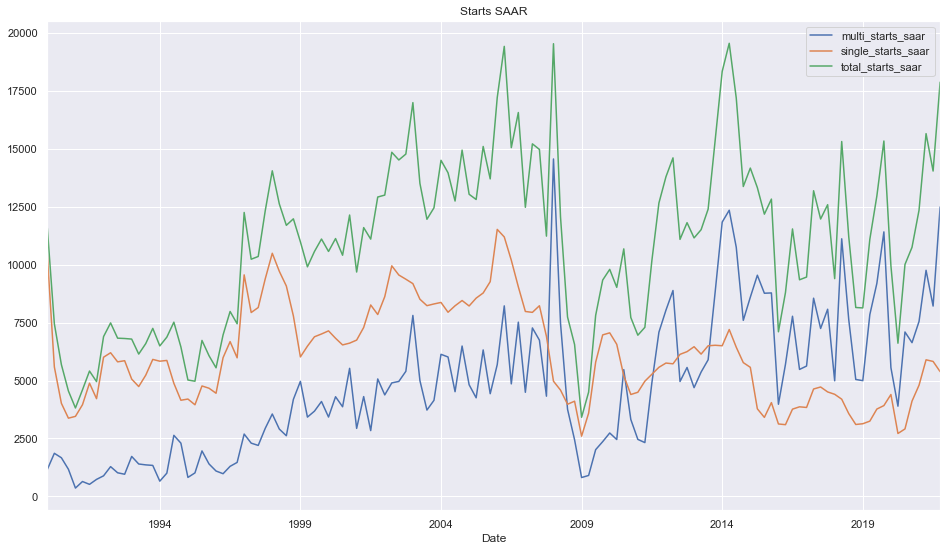

In [62]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,9))

df['1990':].plot(ax=ax,title='Starts SAAR')


In [63]:
real_income = pd.read_excel('../data/BaselineProvincialForecasts.xlsx',sheet_name='RealDisposableIncome',engine='openpyxl',index_col=0)[['AB']]
real_income.rename({'AB':'RealDisposableIncome'},axis=1,inplace=True)

real_gdp = pd.read_excel('../data/BaselineProvincialForecasts.xlsx',sheet_name='RealGDP',engine='openpyxl',index_col=0)[['AB']]
real_gdp.rename({'AB':'RealGDP'},axis=1,inplace=True)

unemp = pd.read_excel('../data/BaselineProvincialForecasts.xlsx',sheet_name='Unemployment',engine='openpyxl',index_col=0)[['AB']]
unemp.rename({'AB':'Unemployment'},axis=1,inplace=True)

employment = pd.read_excel('../data/BaselineProvincialForecasts.xlsx',sheet_name='Employment',engine='openpyxl',index_col=0)[['AB']]
employment.rename({'AB':'Employment'},axis=1,inplace=True)

cpi = pd.read_excel('../data/BaselineProvincialForecasts.xlsx',sheet_name='CPI',engine='openpyxl',index_col=0,header=1)[['AB']]
cpi.rename({'AB':'CPI'},axis=1,inplace=True)

prov_econ=real_gdp.join(real_income)
prov_econ=prov_econ.join(unemp)
prov_econ=prov_econ.join(employment)
prov_econ=prov_econ.join(cpi)
prov_econ.index=prov_econ.index.rename('Date')
prov_econ.index=pd.PeriodIndex(prov_econ.index,freq='Q').to_timestamp()


In [64]:
nat_econ=pd.read_excel('../data/BaselineNationalForecasts.xlsx',header=1,index_col=0,engine='openpyxl',sheet_name='Quarterly')[3:-11]
energy = pd.read_excel('../data/BaselineNationalForecasts.xlsx',sheet_name='Energy',header=0,index_col=0,engine='openpyxl')
covid = pd.read_excel('../data/BaselineNationalForecasts.xlsx',sheet_name='COVID',header=0,index_col=0,engine='openpyxl')

In [65]:
nat_econ.index = nat_econ.index.str.replace(' ','')
nat_econ.index=nat_econ.index.rename('Date')
nat_econ.index=pd.PeriodIndex(nat_econ.index,freq='Q').to_timestamp()
energy.index = energy.index.str.replace(' ','')
energy.index=energy.index.rename('Date')
energy.index=pd.PeriodIndex(energy.index,freq='Q').to_timestamp()
covid.index = covid.index.str.replace(' ','')
covid.index=covid.index.rename('Date')
covid.index=pd.PeriodIndex(covid.index,freq='Q').to_timestamp()


In [66]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'mean error':me, 'mae': mae, 
            'mean percentage error': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})
        

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

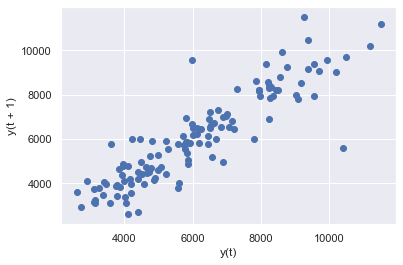

In [67]:
pd.plotting.lag_plot(df['single_starts_saar']['1988':])


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

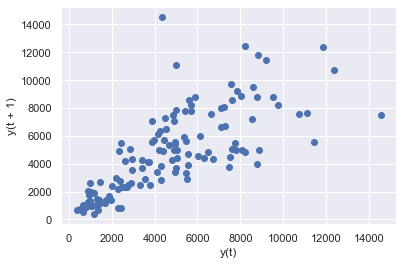

In [68]:
pd.plotting.lag_plot(df['multi_starts_saar']['1988':])


In [69]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [93]:
test_df = prov_econ.join(df).join(energy).join(nat_econ).join(covid)

In [95]:
test_df['2000']

C:\Users\makmi\AppData\Local\Temp\ipykernel_15380\333981453.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  test_df['2000']


,RealGDP,RealDisposableIncome,Unemployment,Employment,CPI,multi_starts_saar,single_starts_saar,total_starts_saar,WTI_Base,WTI_Supply_Chain_Disruption,...,"Income, personal disposable, real, LCU","Interest rate, central bank policy","Interest rate, 10-Year Benchmark Bond Yield",Interest rate on fixed 5-year mortgages [%],"Corporate borrowing rate, period average","World oil price, Brent crude spot, $pb",World Price Oil (West Texas Intermediate),"World oil price, Western Canada Select (WCS) crude, $pb",COVID-19,Long COVID
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,214820.797,74474.588189,5.000000,1570.031565,93.077188,3425.0,7141.0,10566.0,28.80667,28.80667,...,175110.3,4.945313,6.274844,8.336667,5.790514,26.92667,28.80667,0.001,0.0,0.0
2000-04-01,218113.970,75951.376795,4.866667,1578.418306,93.650005,4300.0,6822.0,11122.0,28.78333,28.78333,...,177032.8,5.503968,6.015714,8.356667,5.558257,26.76667,28.78333,0.001,0.0,0.0
2000-07-01,220338.932,77904.202574,5.100000,1586.292466,95.162836,3868.0,6535.0,10403.0,31.62333,31.62333,...,179488.1,5.75,5.785807,8.113334,5.175855,30.67333,31.62333,0.001,0.0,0.0
2000-10-01,221438.301,80477.476394,4.900000,1601.625708,96.283956,5525.0,6612.0,12137.0,31.98000,31.98000,...,182779.1,5.75,5.62459,7.976666,5.39623,29.72333,31.98,0.001,0.0,0.0


RMSE: 972.009


C:\Users\makmi\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


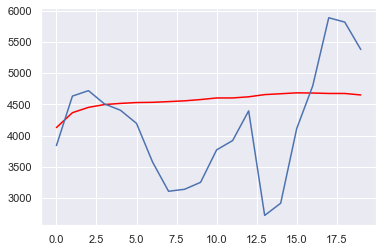

In [73]:
history_df=test_df['1990':'2021']
val = np.array(history_df[['single_starts_saar']].values,dtype=float)
size = int(len(val)*0.85)
train, test = val[0:size], val[size:len(val)]
history=[x for x in train]
exog = np.array(history_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19']].values,dtype=float)
exog_train, exog_test = exog[0:size], exog[size:len(exog)]
exog_train = np.array(exog_train, dtype=float)
predictions = list()
model = SARIMAX(history,order=(1,1,4), seasonal_order=(0,0,0,0),exog=exog_train)
model_fit=model.fit()
output=model_fit.get_forecast(len(test), exog=exog_test)
rmse=math.sqrt(mean_squared_error(test,output.summary_frame()['mean']))
print('RMSE: %.3f' % rmse)
plt.plot(output.summary_frame()['mean'],color='red')
plt.plot(test)

In [74]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(1, 1, 4)   Log Likelihood                -885.734
Date:                Sun, 20 Feb 2022   AIC                           1789.468
Time:                        13:25:20   BIC                           1813.523
Sample:                             0   HQIC                          1799.220
                                - 108                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.0587     11.516     -0.092      0.927     -23.631      21.513
x2           -95.5682    222.754     -0.429      0.668    -532.158     341.021
const               0      0.001          0      1.000      -0.003       0.003
ar.L1          0.6098      0.257      2.371      0.018       0.106       1.114
ma.L1         -0.7185      0.270     -2.663      0.008      -1.247      -0.190
ma.L2         -0.0021      0.083     -0.025      0.980      -0.165       0.160
ma.L3          0.0020      0.096      0.021      0.984      -0.186       0.190
ma.L4         -0.1305      0.089     -1.461      0.144      -0.306       0.045
sigma2      7.849e+05   7.86e+04      9.984      0.000    6.31e+05    9.39e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.83   Jarque-Bera (JB):                87.49
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -0.23
Prob(H) (two-sided):                  0.03   Kurtosis:                         7.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.15e+30. Standard errors may be unstable.
"""

RMSE: 2145.031


C:\Users\makmi\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


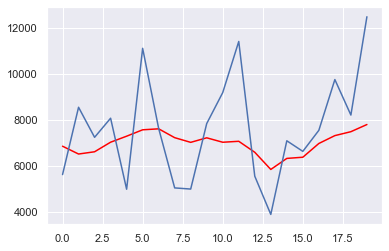

In [75]:
history_df=test_df['1990':'2021']
val = np.array(history_df[['multi_starts_saar']].values,dtype=float)
size = int(len(val)*0.85)
train, test = val[0:size], val[size:len(val)]
history=[x for x in train]
exog = np.array(history_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19']].values,dtype=float)
exog_train, exog_test = exog[0:size], exog[size:len(exog)]
exog_train = np.array(exog_train, dtype=float)
predictions = list()
model = SARIMAX(history,order=(1,1,4), seasonal_order=(0,0,0,0),exog=exog_train)
model_fit=model.fit()
output=model_fit.get_forecast(len(test), exog=exog_test)
rmse=math.sqrt(mean_squared_error(test,output.summary_frame()['mean']))
print('RMSE: %.3f' % rmse)
plt.plot(output.summary_frame()['mean'],color='red')
plt.plot(test)

In [76]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(1, 1, 4)   Log Likelihood                -947.552
Date:                Sun, 20 Feb 2022   AIC                           1913.103
Time:                        13:25:24   BIC                           1937.158
Sample:                             0   HQIC                          1922.855
                                - 108                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            40.8574     15.119      2.702      0.007      11.225      70.490
x2           146.5655    501.700      0.292      0.770    -836.748    1129.879
const               0   2.51e-07          0      1.000   -4.92e-07    4.92e-07
ar.L1         -0.8302      0.065    -12.832      0.000      -0.957      -0.703
ma.L1          0.3682      0.160      2.303      0.021       0.055       0.682
ma.L2         -0.5573      0.094     -5.943      0.000      -0.741      -0.373
ma.L3         -0.0229      0.112     -0.204      0.838      -0.243       0.197
ma.L4         -0.0974      0.121     -0.803      0.422      -0.335       0.140
sigma2      2.795e+06      0.000   9.15e+09      0.000     2.8e+06     2.8e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                32.02
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              11.29   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.55e+28. Standard errors may be unstable.
"""

In [77]:
output.summary_frame()['mean']

0     6857.206079
1     6517.703369
2     6615.745832
3     7031.664912
4     7292.509845
5     7570.336747
6     7612.763401
7     7228.520512
8     7025.059373
9     7222.040395
10    7029.583273
11    7071.243296
12    6593.433255
13    5847.289373
14    6326.948684
15    6378.690913
16    6976.089460
17    7317.943328
18    7488.440640
19    7799.317066
Name: mean, dtype: float64

In [89]:
test_df

,multi_starts_saar,single_starts_saar,total_starts_saar,"GDP, real, LCU",Unemployment rate,Consumer price index,"Employment, total","Income, personal disposable, real, LCU","Interest rate, central bank policy","Interest rate, 10-Year Benchmark Bond Yield",...,WTI_Consumer_Boom,WTI_Return_Of_Inflation,WTI_CMHC,RealGDP,RealDisposableIncome,Unemployment,Employment,CPI,COVID-19,Long COVID
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,NaN,NaN,NaN,209975,7.566667,42.27958,10894.47,115510.7,0.001,0.001,...,35.83333,35.83333,35.83333,NaN,NaN,NaN,NaN,NaN,0,0
1980-04-01,NaN,NaN,NaN,209908.3,7.733333,43.4352,10922.27,116036,0.001,0.001,...,39.50000,39.50000,39.50000,NaN,NaN,NaN,NaN,NaN,0,0
1980-07-01,NaN,NaN,NaN,209667.3,7.5,44.63581,10985.7,116670.7,0.001,0.001,...,37.83333,37.83333,37.83333,NaN,NaN,NaN,NaN,NaN,0,0
1980-10-01,NaN,NaN,NaN,212561,7.266667,45.90552,11116.7,118399.8,0.001,0.001,...,36.33333,36.33333,36.33333,NaN,NaN,NaN,NaN,NaN,0,0
1981-01-01,NaN,NaN,NaN,217245.8,7.4,47.42812,11256.2,120058.5,0.001,0.001,...,38.00000,38.00000,38.00000,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01,6633.0,4111.0,10744.0,508326.3,8.666667,137.9333,18574.03,321462.4,0.25,0.673871,...,42.50667,42.50667,42.50667,329333.226579,158136.152051,11.166667,2212.269618,145.512828,1,1
2021-01-01,7548.0,4798.0,12346.0,505411.1,9.231546,138.4327,18451.79,321299.8,0.25,1.151935,...,57.82333,57.82333,57.82333,337875.289218,160030.404207,9.933333,2200.112302,146.352459,0,1
2021-04-01,9754.0,5893.0,15647.0,513315.7,8.815559,138.8804,18642.32,325236.7,0.25,1.486825,...,66.09000,66.09000,66.09000,337225.574971,160905.040529,8.733333,2210.822897,148.191545,0,0


C:\Users\makmi\AppData\Local\Temp\ipykernel_15380\691840439.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(fcast_res[['mean']])


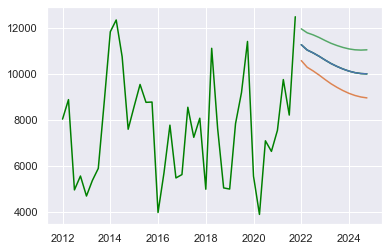

In [147]:
history_df=test_df['1988':'2021']
val = np.array(history_df[['multi_starts_saar']].values,dtype=float)

exog =  np.array(test_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19']]['1988':'2021'].values,dtype=float)
exog_fcast = np.array(test_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19']]['2022':'2024'].values,dtype=float)


model = SARIMAX(val,order=(0,1,2), seasonal_order=(0,0,0,0),exog=exog)
model_fit=model.fit()
f_cast = model_fit.get_forecast(12,exog=exog_fcast)
fcast_res = f_cast.summary_frame(alpha = 0.7)
fcast_res.index= pd.date_range(start='2022',periods=12,freq='qs-oct')

history = test_df[['multi_starts_saar']]['2012':]
history=history.append(fcast_res[['mean']])
#history.index = pd.date_range(start='2019',end='2025',freq='qs-oct')
plt.plot(history,color='green')

plt.plot(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2020':])

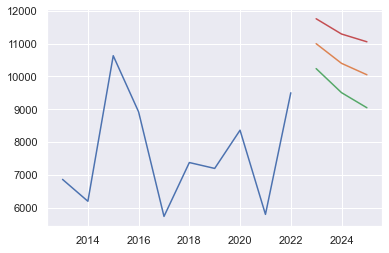

In [148]:
plt.plot(history[['multi_starts_saar']].join(fcast_res[['mean','mean_ci_lower','mean_ci_upper']])[:'2024'].resample('A').mean())

In [149]:
history[['multi_starts_saar']].join(fcast_res[['mean','mean_ci_lower','mean_ci_upper']])[:'2024'].resample('A').mean()

,multi_starts_saar,mean,mean_ci_lower,mean_ci_upper
2012-12-31,6859.25,NaN,NaN,NaN
2013-12-31,6192.75,NaN,NaN,NaN
2014-12-31,10629.00,NaN,NaN,NaN
2015-12-31,8918.75,NaN,NaN,NaN
2016-12-31,5731.00,NaN,NaN,NaN
2017-12-31,7373.00,NaN,NaN,NaN
2018-12-31,7193.75,NaN,NaN,NaN
2019-12-31,8358.50,NaN,NaN,NaN
2020-12-31,5793.25,NaN,NaN,NaN
2021-12-31,9499.25,NaN,NaN,NaN


C:\Users\makmi\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\makmi\AppData\Local\Temp\ipykernel_15380\166133933.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(fcast_res[['mean']])


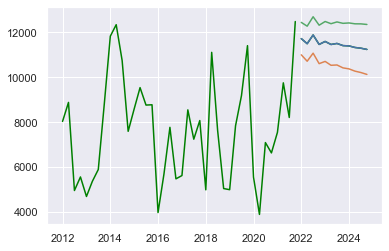

In [133]:
history_df=test_df['1988':'2021']
val = np.array(history_df[['multi_starts_saar']].values,dtype=float)

exog =  np.array(test_df[['WTI_CMHC','Interest rate on fixed 5-year mortgages [%]','COVID-19']]['1988':'2021'].values,dtype=float)
exog_fcast = np.array(test_df[['WTI_CMHC','Interest rate on fixed 5-year mortgages [%]','COVID-19']]['2022':'2024'].values,dtype=float)


model = SARIMAX(val,order=(1,1,2), seasonal_order=(0,0,0,0),exog=exog)
model_fit=model.fit()
f_cast = model_fit.get_forecast(12,exog=exog_fcast)
fcast_res = f_cast.summary_frame(alpha = 0.7)
fcast_res.index= pd.date_range(start='2022',periods=12,freq='qs-oct')

history = test_df[['multi_starts_saar']]['2012':]
history=history.append(fcast_res[['mean']])
#history.index = pd.date_range(start='2019',end='2025',freq='qs-oct')
plt.plot(history,color='green')

plt.plot(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2020':])

C:\Users\makmi\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\makmi\AppData\Local\Temp\ipykernel_15380\1472842007.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(fcast_res[['mean']])


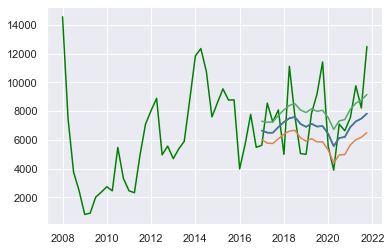

In [120]:
history_df=test_df['1988':'2016']
val = np.array(history_df[['multi_starts_saar']].values,dtype=float)

exog =  np.array(test_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19']]['1988':'2016'].values,dtype=float)
exog_fcast = np.array(test_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19']]['2017':'2021'].values,dtype=float)


model = SARIMAX(val,order=(1,1,2), seasonal_order=(0,0,0,0),exog=exog)
model_fit=model.fit()
f_cast = model_fit.get_forecast(20,exog=exog_fcast)
fcast_res = f_cast.summary_frame(alpha = 0.7)
fcast_res.index= pd.date_range(start='2017',periods=20,freq='qs-oct')

history = test_df[['multi_starts_saar']]['2008':]
history=history.append(fcast_res[['mean']])
#history.index = pd.date_range(start='2019',end='2025',freq='qs-oct')
plt.plot(history,color='green')

plt.plot(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2017':])

In [121]:
history.resample('A').mean()

,multi_starts_saar,mean
2008-12-31,7058.50,NaN
2009-12-31,1526.00,NaN
2010-12-31,3495.75,NaN
2011-12-31,4195.00,NaN
2012-12-31,6859.25,NaN
2013-12-31,6192.75,NaN
2014-12-31,10629.00,NaN
2015-12-31,8918.75,NaN
2016-12-31,5731.00,NaN
2017-12-31,7373.00,6630.924036


In [119]:
fcast_res[['mean','mean_ci_lower','mean_ci_upper']].resample('A').mean()

y,mean,mean_ci_lower,mean_ci_upper
2017-12-31,6630.924036,6148.735018,7113.113054
2018-12-31,7357.814770,6762.127011,7953.502530
2019-12-31,6973.599545,6285.079938,7662.119151
2020-12-31,6077.533389,5307.902444,6847.164334
2021-12-31,7366.513000,6523.721488,8209.304512


In [131]:
history[['multi_starts_saar']].join(fcast_res[['mean','mean_ci_lower','mean_ci_upper']])[:'2021'].resample('A').mean()

,multi_starts_saar,mean,mean_ci_lower,mean_ci_upper
2008-12-31,7058.50,NaN,NaN,NaN
2009-12-31,1526.00,NaN,NaN,NaN
2010-12-31,3495.75,NaN,NaN,NaN
2011-12-31,4195.00,NaN,NaN,NaN
2012-12-31,6859.25,NaN,NaN,NaN
2013-12-31,6192.75,NaN,NaN,NaN
2014-12-31,10629.00,NaN,NaN,NaN
2015-12-31,8918.75,NaN,NaN,NaN
2016-12-31,5731.00,NaN,NaN,NaN
2017-12-31,7373.00,6630.924036,5897.553514,7364.294558


C:\Users\makmi\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\makmi\AppData\Local\Temp\ipykernel_15380\1743213749.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(fcast_res[['mean']])


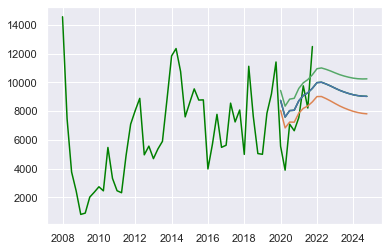

In [151]:
history_df=test_df['1988':'2019']
val = np.array(history_df[['multi_starts_saar']].values,dtype=float)

exog =  np.array(test_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19']]['1988':'2019'].values,dtype=float)
exog_fcast = np.array(test_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19']]['2020':'2024'].values,dtype=float)


model = SARIMAX(val,order=(1,1,2), seasonal_order=(0,0,0,0),exog=exog)
model_fit=model.fit()
f_cast = model_fit.get_forecast(20,exog=exog_fcast)
fcast_res = f_cast.summary_frame(alpha = 0.7)
fcast_res.index= pd.date_range(start='2020',periods=20,freq='qs-oct')

history = test_df[['multi_starts_saar']]['2008':]
history=history.append(fcast_res[['mean']])
#history.index = pd.date_range(start='2019',end='2025',freq='qs-oct')
plt.plot(history,color='green')

plt.plot(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2020':])

In [154]:
history[['multi_starts_saar']].join(fcast_res[['mean','mean_ci_lower','mean_ci_upper']])[:'2024'].resample('A').mean()

,multi_starts_saar,mean,mean_ci_lower,mean_ci_upper
2008-12-31,7058.50,NaN,NaN,NaN
2009-12-31,1526.00,NaN,NaN,NaN
2010-12-31,3495.75,NaN,NaN,NaN
2011-12-31,4195.00,NaN,NaN,NaN
2012-12-31,6859.25,NaN,NaN,NaN
2013-12-31,6192.75,NaN,NaN,NaN
2014-12-31,10629.00,NaN,NaN,NaN
2015-12-31,8918.75,NaN,NaN,NaN
2016-12-31,5731.00,NaN,NaN,NaN
2017-12-31,7373.00,NaN,NaN,NaN


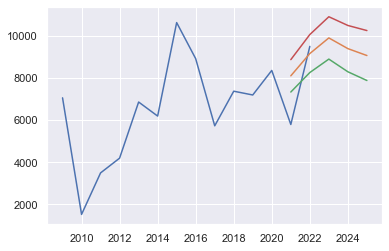

In [155]:
plt.plot(history[['multi_starts_saar']].join(fcast_res[['mean','mean_ci_lower','mean_ci_upper']])[:'2024'].resample('A').mean())

C:\Users\makmi\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\makmi\AppData\Local\Temp\ipykernel_15380\1026272179.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(fcast_res[['mean']])


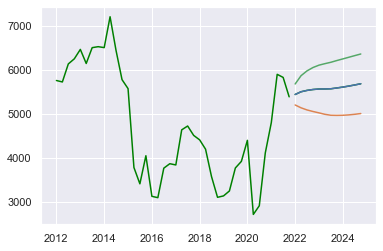

In [108]:
history_df=test_df['1988':'2021']
val = np.array(history_df[['single_starts_saar']].values,dtype=float)

exog =  np.array(test_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19']]['1988':'2021'].values,dtype=float)
exog_fcast = np.array(test_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19']]['2022':'2024'].values,dtype=float)


model = SARIMAX(val,order=(1,1,2), seasonal_order=(0,0,0,0),exog=exog)
model_fit=model.fit()
f_cast = model_fit.get_forecast(12,exog=exog_fcast)
fcast_res = f_cast.summary_frame(alpha = 0.8)
fcast_res.index= pd.date_range(start='2022',periods=12,freq='qs-oct')

history = test_df[['single_starts_saar']]['2012':]
history=history.append(fcast_res[['mean']])
#history.index = pd.date_range(start='2019',end='2025',freq='qs-oct')
plt.plot(history,color='green')

plt.plot(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2020':])

In [109]:
history.resample('A').mean()

,single_starts_saar,mean
2012-12-31,5961.75,NaN
2013-12-31,6403.75,NaN
2014-12-31,6476.50,NaN
2015-12-31,4201.50,NaN
2016-12-31,3463.25,NaN
2017-12-31,4425.25,NaN
2018-12-31,3820.00,NaN
2019-12-31,3518.00,NaN
2020-12-31,3533.75,NaN
2021-12-31,5474.25,NaN


C:\Users\makmi\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\makmi\AppData\Local\Temp\ipykernel_15380\551942078.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(fcast_res[['mean']])


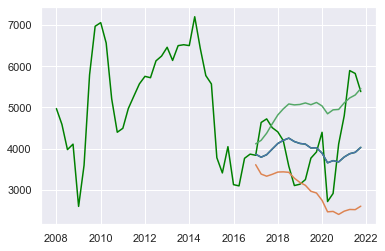

In [135]:
history_df=test_df['1988':'2016']
val = np.array(history_df[['single_starts_saar']].values,dtype=float)

exog =  np.array(test_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19']]['1988':'2016'].values,dtype=float)
exog_fcast = np.array(test_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19']]['2017':'2021'].values,dtype=float)


model = SARIMAX(val,order=(1,1,2), seasonal_order=(0,0,0,0),exog=exog)
model_fit=model.fit()
f_cast = model_fit.get_forecast(20,exog=exog_fcast)
fcast_res = f_cast.summary_frame(alpha = 0.8)
fcast_res.index= pd.date_range(start='2017',periods=20,freq='qs-oct')

history = test_df[['single_starts_saar']]['2008':]
history=history.append(fcast_res[['mean']])
#history.index = pd.date_range(start='2019',end='2025',freq='qs-oct')
plt.plot(history,color='green')

plt.plot(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2017':])

In [136]:
history[['single_starts_saar']].join(fcast_res[['mean','mean_ci_lower','mean_ci_upper']])[:'2021'].resample('A').mean()

,single_starts_saar,mean,mean_ci_lower,mean_ci_upper
2008-12-31,4410.25,NaN,NaN,NaN
2009-12-31,4738.00,NaN,NaN,NaN
2010-12-31,5805.50,NaN,NaN,NaN
2011-12-31,5076.25,NaN,NaN,NaN
2012-12-31,5961.75,NaN,NaN,NaN
2013-12-31,6403.75,NaN,NaN,NaN
2014-12-31,6476.50,NaN,NaN,NaN
2015-12-31,4201.50,NaN,NaN,NaN
2016-12-31,3463.25,NaN,NaN,NaN
2017-12-31,4425.25,3873.888952,3424.581295,4323.196608


C:\Users\makmi\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\makmi\AppData\Local\Temp\ipykernel_15380\2790984171.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(fcast_res[['mean']])


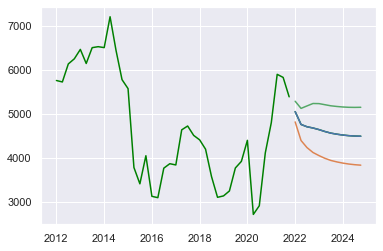

In [156]:
history_df=test_df['1988':'2021']
val = np.array(history_df[['single_starts_saar']].values,dtype=float)

exog =  np.array(test_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19']]['1988':'2021'].values,dtype=float)
exog_fcast = np.array(test_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19']]['2022':'2024'].values,dtype=float)


model = SARIMAX(val,order=(1,1,4), seasonal_order=(0,0,0,0),exog=exog)
model_fit=model.fit()
f_cast = model_fit.get_forecast(12,exog=exog_fcast)
fcast_res = f_cast.summary_frame(alpha = 0.8)
fcast_res.index= pd.date_range(start='2022',periods=12,freq='qs-oct')

history = test_df[['single_starts_saar']]['2012':]
history=history.append(fcast_res[['mean']])
#history.index = pd.date_range(start='2019',end='2025',freq='qs-oct')
plt.plot(history,color='green')

plt.plot(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2020':])